In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from utils import *

seed=42
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/tmp'),
 PosixPath('data/test_nextclick_FE.feather'),
 PosixPath('data/submission'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/xgb2.model'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/dtree.dot'),
 PosixPath('data/test_FE.feather'),
 PosixPath('data/xgb1.model'),
 PosixPath('data/models'),
 PosixPath('data/val_idxs.p'),
 PosixPath('data/train_day8_3to16_nextclick_FE.feather'),
 PosixPath('data/mean_enc_df'),
 PosixPath('data/xgb1_noratio.model'),
 PosixPath('data/train_day9_3to16_nextclick_FE.feather'),
 PosixPath('data/validation'),
 PosixPath('data/xgb_FE_best_more.model')]

In [2]:
from fastai.structured import *
from fastai.column_data import *

In [3]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*10, shuffle=False, num_workers=1), test_dl) # increased validation batch size

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, is_reg=True, is_multi=False, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs), is_reg=is_reg, is_multi=is_multi) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y, is_reg=is_reg, is_multi=is_multi),
                   PassthruDataset(*(val_xs.T), val_y, is_reg=is_reg, is_multi=is_multi),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None, is_reg, is_multi) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y, is_reg, is_multi),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y, is_reg, is_multi), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, is_reg=True, is_multi=False, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

# Prepare data

In [4]:
cols_to_drop =['is_attributed','ip','day','device']
train_filename = 'train_day8_3to16_nextclick_FE.feather'

In [5]:
# Sample run

val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val2.feather',
 'data/validation/val0.feather',
 'data/validation/val1.feather']

In [6]:
n_train=3000000

In [7]:
nan_cols = ['ip_next_click',
 'ip_prev_click',
 'ip_app_next_click',
 'ip_app_prev_click',
 'ip_channel_next_click',
 'ip_channel_prev_click',
 'ip_os_next_click',
 'ip_os_prev_click',
 'ip_os_device_next_click',
 'ip_os_device_prev_click',
 'ip_os_device_app_next_click',
 'ip_os_device_app_prev_click']

In [8]:
train_filename = 'train_day8_3to16_nextclick_FE.feather'
train_df,y_train = get_train(cols_to_drop,train_filename,n_train)
train_df['Target'] = y_train

del y_train
gc.collect()

7

In [9]:
train_df.loc[:,nan_cols] = train_df.loc[:,nan_cols].fillna(0)

In [10]:
val_names='data/validation/val2.feather'
val_df,y_val = get_val_by_name(cols_to_drop,val_names)
val_df['Target'] = y_val

del y_val
gc.collect()

7

In [11]:
val_df.loc[:,nan_cols] = val_df.loc[:,nan_cols].fillna(0)

In [12]:
n_val = 2000000
val_df = val_df.loc[:n_val,:].copy()

In [13]:
print(val_df.shape)

(2000001, 43)


In [14]:
gc.collect()

42

In [15]:
cat_vars = ['hour','minute','channel','os','app','second']
contin_vars = [i for i in list(train_df.columns) if i not in cat_vars and i != 'Target']

In [16]:
n = len(train_df)
print(train_df.shape)
for v in cat_vars: train_df[v] = train_df[v].astype('category').cat.as_ordered()

(3000000, 43)


In [17]:
apply_cats(val_df,train_df)

In [18]:
for v in contin_vars:
    train_df[v]= train_df[v].astype('float32')
    val_df[v] = val_df[v].astype('float32')

In [19]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

print(emb_szs)

[(15, 8), (61, 31), (172, 50), (239, 50), (336, 50), (61, 31)]


In [20]:
cat_sz

[('hour', 15),
 ('minute', 61),
 ('channel', 172),
 ('os', 239),
 ('app', 336),
 ('second', 61)]

In [21]:
emb_dr=0.4
nn_list=[700,600]
nn_dr=[0.3,0.3]

In [22]:
# def fix_missing(df, col, name):
#     if is_numeric_dtype(col):
#         if pd.isnull(col).sum():
#             filler = na_dict[name] if name in na_dict else col.median()
#             df[name] = col.fillna(filler)
#             na_dict[name] = filler
#     return na_dict

# def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
#             preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

#     for n,c in df.items(): na_dict = fix_missing(df, c, n)
#     if do_scale: mapper = scale_vars(df, mapper)
#     for n,c in df.items(): numericalize(df, c, n, max_n_cat)
#     df = pd.get_dummies(df, dummy_na=True)
#     df = pd.concat([ignored_flds, df], axis=1)
#     res = [df, y, na_dict]
#     if do_scale: res = res + [mapper]
#     return res

In [23]:
df_train, y_train, nas, mapper = proc_df(train_df, 'Target', do_scale=True)
del train_df
gc.collect()

94

In [24]:
df_val, y_val, nas, mapper = proc_df(val_df, 'Target', do_scale=True,mapper = mapper)
del val_df
gc.collect()

135

In [25]:
for v in contin_vars:
    df_train[v]= df_train[v].astype('float32')
    df_val[v] = df_val[v].astype('float32')

In [26]:
df_train.shape
df_val.shape

(3000000, 42)

(2000001, 42)

In [27]:
len(cat_vars)+ len(contin_vars)

42

In [28]:
# del model,md
# gc.collect()

In [29]:
bs = 75000
md = ColumnarModelData.from_data_frames(str(PATH), df_train,df_val, 
                                        y_train.astype('int'), y_val.astype('int'),
                                        cat_flds=cat_vars, 
                                        bs=bs,
                                        is_reg=False,
                                        is_multi=False)

# m = md.get_learner(emb_szs,len(df_train.columns)-len(cat_vars),emb_dr,1,nn_list,nn_dr,use_bn=True)

In [30]:
model = to_gpu(MixedInputModel(emb_szs,
                               len(df_train.columns)-len(cat_vars),
                               emb_dr,
                               2,
                               nn_list,
                               nn_dr,
                               is_reg=False,
                               is_multi=False,
                               use_bn=True))
bm = BasicModel(model, 'binary_classifier')


In [31]:
gc.collect()

28

In [32]:
def imbalanced_loss(inp,targ):
    return F.nll_loss(inp,targ,weight=T([.01,.99]))
def auc(inp,targ):
    return roc_auc_score(to_np(targ),to_np(np.exp(inp[:,1])))

In [33]:
# del learn
# gc.collect()

In [34]:
learn = StructuredLearner(md, bm)
learn.crit = imbalanced_loss
learn.crit

<function __main__.imbalanced_loss(inp, targ)>

In [39]:
learn.lr_find()


 39%|███▉      | 15/38 [00:09<00:15,  1.51it/s, loss=0.76] 

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 34/38 [00:21<00:02,  1.61it/s, loss=659]  

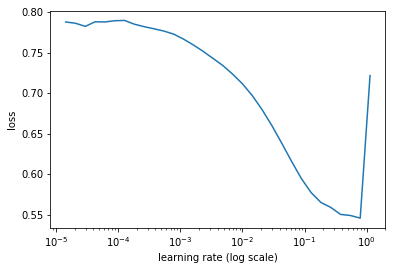

In [40]:
learn.sched.plot(n_skip=1, n_skip_end=0)

# Use_clr

In [35]:
lr = 0.1
learn.fit(lr, 20,metrics=[auc],cycle_len=1,use_clr=(10,4),
          best_save_name='nn700600best')

 40%|████      | 16/40 [00:10<00:15,  1.60it/s, loss=0.365]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                       
    0      0.249466   0.188292   0.939607  
    1      0.187474   0.180418   0.939689                  
    2      0.167709   0.1796     0.941694                  
    3      0.158191   0.177169   0.943913                  
    4      0.153993   0.175416   0.945449                  
    5      0.150289   0.173401   0.947404                  
    6      0.148162   0.172026   0.949789                  
    7      0.145727   0.169851   0.951795                  
    8      0.143946   0.16828    0.954124                  
    9      0.141938   0.166671   0.955828                  
    10     0.139889   0.165016   0.957605                  
    11     0.139214   0.164425   0.958871                  
    12     0.137029   0.162486   0.959472                  
    13     0.135992   0.160175   0.960033                  
    14     0.135145   0.160081   0.959943                  
    15     0.133725   0.161357   0.960083               

[array([0.15799]), 0.9606924740176395]

In [36]:
lr = 0.1
learn.fit(lr, 10,metrics=[auc],cycle_len=1,use_clr=(10,3),
          best_save_name='nn700600best')

 45%|████▌     | 18/40 [00:09<00:12,  1.81it/s, loss=0.134]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                       
    0      0.130137   0.158256   0.96079   
    1      0.130581   0.157434   0.96115                   
    2      0.130055   0.157576   0.960773                  
    3      0.129609   0.159115   0.961043                  
    4      0.129111   0.157329   0.961271                  
    5      0.128286   0.156915   0.961756                  
    6      0.127916   0.156943   0.961573                  
    7      0.127723   0.157562   0.961783                  
    8      0.127215   0.156029   0.961723                  
    9      0.127187   0.158092   0.962036                  



[array([0.15809]), 0.9620364201419284]

In [31]:
learn.load('nn700700best')
lr = 0.1
learn.fit(lr, 10,metrics=[auc],cycle_len=1,use_clr=(10,3),
          best_save_name='nn700700best_2')

 40%|████      | 20/50 [00:09<00:13,  2.20it/s, loss=0.113]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                       
    0      0.110562   0.136743   0.971393  
    1      0.110527   0.136507   0.971455                  
    2      0.109905   0.135838   0.971809                  
    3      0.11022    0.136122   0.97169                   
    4      0.110691   0.136423   0.97163                   
    5      0.109522   0.135802   0.971783                  
    6      0.109626   0.134951   0.972051                  
    7      0.108758   0.134656   0.972136                  
    8      0.108471   0.135093   0.972178                  
    9      0.108232   0.134736   0.972408                  


[array([0.13474]), 0.9724076455294064]

In [32]:
learn.load('nn700700best_2')
lr = 0.1
learn.fit(lr, 20,metrics=[auc],cycle_len=1,use_clr=(10,3),
          best_save_name='nn700700best_2')

 14%|█▍        | 7/50 [00:03<00:22,  1.92it/s, loss=0.105] 

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                       
    0      0.106745   0.134866   0.972483  
    1      0.107188   0.13476    0.972282                  
    2      0.106509   0.13454    0.972436                  
    3      0.106503   0.134928   0.972363                  
    4      0.105479   0.13482    0.972657                  
    5      0.105948   0.134174   0.972605                  
    6      0.106527   0.133745   0.972851                  
    7      0.106088   0.134816   0.972632                  
    8      0.10612    0.134407   0.97265                   
    9      0.104908   0.134273   0.972885                  
    10     0.105057   0.13421    0.972991                  
    11     0.104045   0.134525   0.972716                  
    12     0.104197   0.1343     0.972712                  
    13     0.103926   0.135457   0.972739                  
    14     0.103912   0.134608   0.972735                  
    15     0.103815   0.134329   0.973058               

[array([0.13426]), 0.972994845023093]

In [36]:
learn.load('nn700700best_3')
lr = 0.05
learn.fit(lr, 5,metrics=[auc],cycle_len=1,use_clr=(5,5),best_save_name='nn700700best_4')

  0%|          | 0/50 [00:00<?, ?it/s]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                        
    0      0.10128    0.134072   0.973162  
    1      0.100998   0.134795   0.973203                   
    2      0.100935   0.134465   0.973238                   
    3      0.100672   0.134488   0.973055                   
    4      0.101942   0.134079   0.973248                   


[array([0.13408]), 0.973247584587075]

In [38]:
learn.load('nn700700best_4')
lr = 0.1
learn.fit(lr, 5,metrics=[auc],cycle_len=1,use_clr=(10,3),best_save_name='nn700700best_5')

 22%|██▏       | 11/50 [00:05<00:20,  1.91it/s, loss=0.103]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                        
    0      0.100824   0.134113   0.973135  
    1      0.101222   0.135116   0.973369                   
    2      0.100864   0.136144   0.973402                  
    3      0.100945   0.135294   0.97315                    
    4      0.099952   0.136745   0.973052                   


[array([0.13674]), 0.9730516704023444]

In [30]:
# lr = 0.1
# learn.fit(lr, 20,metrics=[auc],cycle_len=1,use_clr=(10,4))

 68%|██████▊   | 23/34 [00:10<00:04,  2.27it/s, loss=0.124]

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   auc                       
    0      0.125975   0.149344   0.966231  
    1      0.124432   0.147591   0.96698                   
    2      0.122022   0.146214   0.968286                  
    3      0.120784   0.143232   0.96909                   
    4      0.11971    0.142378   0.970152                  
    5      0.117964   0.140705   0.970583                  
    6      0.116053   0.139456   0.971256                  
    7      0.114184   0.138152   0.971643                  
    8      0.112595   0.138467   0.971758                  
    9      0.111418   0.139397   0.971931                  
    10     0.110692   0.138169   0.972246                  
    11     0.10969    0.138458   0.971988                  
    12     0.109001   0.138285   0.972512                  
    13     0.108314   0.138245   0.972417                  
    14     0.108379   0.135645   0.972753                  
    15     0.10891    0.135095   0.973071               

[array([0.1368]), 0.9731220315345827]

In [39]:
learn.load("nn700700best_4")

In [40]:
preds = learn.predict_dl(md.val_dl)

/home/quantran/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [41]:
preds

array([[-0.06699, -2.73658],
       [-0.0932 , -2.41929],
       [-0.5543 , -0.85443],
       ...,
       [-0.0022 , -6.12163],
       [-0.00527, -5.24812],
       [-0.05164, -2.98921]], dtype=float32)

In [36]:
# expsums = np.exp(preds).sum(axis=1)
# probs = np.exp(preds) / expsums[:, None]
# probs

In [42]:
np.exp(preds)

array([[0.93521, 0.06479],
       [0.91102, 0.08898],
       [0.57447, 0.42553],
       ...,
       [0.99781, 0.00219],
       [0.99474, 0.00526],
       [0.94967, 0.05033]], dtype=float32)

In [ ]:

# val_pred,val_targ=m.predict_with_targs()
# if get_oof:
#     oof_train = np.append(oof_train,val_pred)

# val_loss=loss_metric(val_targ,val_pred)

# print('Val RMSE: {}'.format(val_loss))
# cv_losses.append(val_loss)
# print('6 fold results: {}'.format(cv_losses))

# mean_cv_loss = np.mean(cv_losses)
# print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
# return (oof_train,cv_losses) if get_oof else cv_losses